In [24]:
from qiskit import QuantumCircuit,Aer, execute,transpile,Aer
import numpy as np
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit.visualization import plot_histogram, plot_bloch_multivector,plot_bloch_vector
import matplotlib.pyplot as plt
from qiskit.quantum_info import DensityMatrix
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity

In [25]:

def get_operator_list(measurement_list):
    '''
    function that return matrix representation of measurement operators given a list of measurement_directions
    
    Arg: measurement_list , a list of state_vectors. (2 state_vectors per direction)
    Returns a list of operators
    '''
    op_list=[]
    
    for state in measurement_list:
        operator=np.outer(state,state)
        operator=operator/(len(measurement_list)/2)
        op_list.append(operator)
        
    return np.array(op_list)

def spherical_to_amplitudes(measurement_directions):
    
    '''
    function that gives state_vectors when measurement directions are given in angles
    Arg: measurement_directions , a list of (theta,phi) tuples for directions
    
    Returns a list of state_vectors , i.e a measurement_list
    '''
    measurement_list=[]
    for basis in measurement_directions:
        a1=np.cos(basis[0]/2)
        b1=np.sin(basis[0]/2)*np.exp(1.0j*basis[1])
        a2=-np.sin([basis[0]/2])
        b2=np.cos([basis[0]/2])*np.exp(1.0j*basis[1])
        positive_direction=[a1,b1]
        negative_direction=[a2,b2]
        measurement_list.append(positive_direction)
        measurement_list.append(negative_direction)
    return measurement_list

def measure_results(measurement_directions,backend,initial_state=np.array([1/np.sqrt(2),1/np.sqrt(2)])):
    '''
    function that gives the counts corresponding to all the measurements
    Arguments: measurement_directions, backend to use and the initial_state of the qubit.
    '''
    
    outcomes=[]
    for basis in measurement_directions:
        circuit=QuantumCircuit(1)
        unitary=QuantumCircuit(1)
        circuit.initialize(initial_state)
        unitary.u(basis[0],basis[1],0,0)
        circuit.append(unitary.inverse(),[0])

        
        circuit.measure_all()
        transpiled_circuit = transpile(circuit, ideal_backend)
        transpiled_circuit.draw('mpl')
        
        plt.show()
        job = backend.run(transpiled_circuit,shots=4000)
        counts = job.result().get_counts()
        
        outcomes.append(counts)
        
    return outcomes

def get_normalized_outcomes(outcomes, weights=None):
    '''
    normalizes the outcomes , so that all results sum to one.
    
    '''
    if weights==None:
        weights=np.zeros(len(outcomes))
        weights+=1/len(outcomes)
    
    normalized_outcomes=outcomes.copy()
    total_counts=0
    for i,counts in enumerate(normalized_outcomes):
        
        total_counts=total_counts+(sum(normalized_outcomes[i].values()))*weights[i]
      
        if len(counts)==1:
            normalized_outcomes[i]['dummy']=0.0
        
    
    for i in range(len(normalized_outcomes)):
        for key in normalized_outcomes[i]:
            normalized_outcomes[i][key]=normalized_outcomes[i][key]*weights[i]/total_counts
    
    
    
    return normalized_outcomes

def normalized_outcomes_to_frequency_vector(normalized_outcomes):
    '''
    Returns the final_frequency vector from normalized_outcomes
    
    '''
    
    dim=len(normalized_outcomes)*2
    f=np.zeros(dim)
    for i,outcomes in enumerate(normalized_outcomes):
        
        f[0+2*i]=outcomes.get('0',0.0)
        f[1+2*i]=outcomes.get('1',0.0)
        
    return f

def get_frequencies(measurement_directions,backend,initial_state=np.array([1,0]),weights=None):
    '''
    Final function that gives frequencies from measurement directions and the initial state of the qubit
    '''
    if weights is not None:
        if len(measurement_directions)!=len(weights):
            print('weights are not of proper dimension ')
    
    
    outcomes=measure_results(measurement_directions,backend,initial_state)
    normalized_outcomes=get_normalized_outcomes(outcomes,weights)
    f=normalized_outcomes_to_frequency_vector(normalized_outcomes)
    return f





## Getting the frequencies for a given initial state and measurement directions

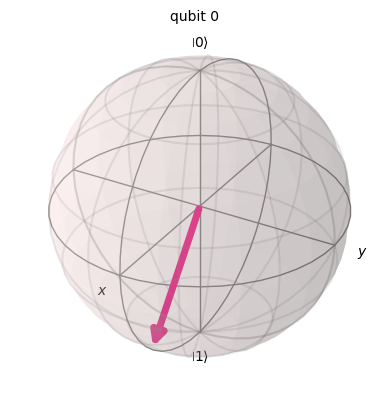

In [34]:
initial_state=[1/3,np.sqrt(1-1/9)]


noisy_backend = FakeManilaV2()                    # backend for noisy measurements

ideal_backend=Aer.get_backend('qasm_simulator')    # Use this for ideal measurements

measurement_directions=[(0,0), (np.pi/2,0)]     # list of (theta, phi) tuples , length = number of measurement directions
     


plot_bloch_multivector(initial_state)


In [27]:
measurement_list=spherical_to_amplitudes(measurement_directions)

operator_list=get_operator_list(measurement_list) 
 ## getting the operator list from measurement directions
for i,op in enumerate(operator_list):
    print('')
    print(f'operator {i} : '  , op)


operator 0 :  [[0.33333333+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j]]

operator 1 :  [[0.        -0.j 0.        +0.j]
 [0.        +0.j 0.33333333+0.j]]

operator 2 :  [[0.16666667+0.j 0.16666667+0.j]
 [0.16666667+0.j 0.16666667+0.j]]

operator 3 :  [[ 0.16666667-0.j -0.16666667+0.j]
 [-0.16666667+0.j  0.16666667+0.j]]

operator 4 :  [[ 1.66666667e-01+0.00000000e+00j  1.02053900e-17+1.66666667e-01j]
 [ 1.02053900e-17+1.66666667e-01j -1.66666667e-01+2.04107800e-17j]]

operator 5 :  [[ 1.66666667e-01-0.00000000e+00j -1.02053900e-17-1.66666667e-01j]
 [-1.02053900e-17-1.66666667e-01j -1.66666667e-01+2.04107800e-17j]]


In [28]:
outcomes=measure_results(measurement_directions,ideal_backend,initial_state)
outcomes   # Each dictionary in this list is the result of a particular measurement direction

[{'1': 3532, '0': 468}, {'1': 2055, '0': 1945}, {'0': 3287, '1': 713}]

In [29]:
normalized_outcomes=get_normalized_outcomes(outcomes)

normalized_outcomes   

[{'1': 0.29433333333333334, '0': 0.039},
 {'1': 0.17125, '0': 0.1620833333333333},
 {'0': 0.27391666666666664, '1': 0.059416666666666666}]

In [30]:

f_vector=normalized_outcomes_to_frequency_vector(normalized_outcomes)

f_vector  # this is the frequency vector we should give to linear Inversion

array([0.039     , 0.29433333, 0.16208333, 0.17125   , 0.27391667,
       0.05941667])

## To add B matrix 

In [31]:
Id=np.array([[1,0],[0,1]])
X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1.0j],[1.0j,0]])

Z=np.array([[1,0],[0,-1]])

Paulis=[Id,X,Y,Z]




In [32]:
operator_list=get_operator_list(spherical_to_amplitudes(measurement_directions)) 

dim1=len(operator_list)


def B_matrix(operator_list):
    dim1=len(operator_list)
    B=np.zeros([dim1,4],dtype=np.complex128)

    for i in range(dim1):
        for j in range(4):
            product=np.dot(operator_list[i],Paulis[j])
            B[i][j]=np.trace(product)

    return B

shape of B :  (6, 4)
The s_vector is : [ 5.00000000e-01 -6.87500000e-03 -5.20417043e-18  5.85000000e-02]
state not positive
r= 0.11780518876518124
theta,phi =  0.11698476737930313 7.569702440626015e-16
fidelity=   0.9952265601308722


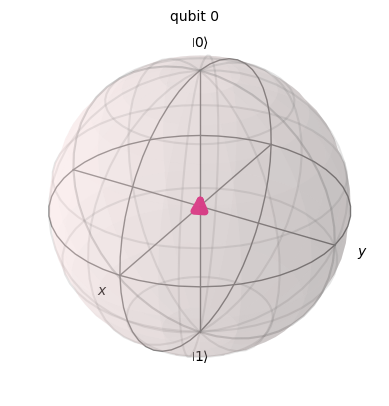

In [33]:
B=B_matrix(operator_list)
print('shape of B : ' ,B.shape)


result=np.linalg.lstsq(B,f_vector, rcond=None)

s_vector=result[0].real

print('The s_vector is :' , s_vector)     # S_vector is just the components of our state in the Pauli basis , the last 3 are the x,y,z coordinates


def rho_from_s(s_vector):
    rho=np.zeros([2,2])
    for pauli,s in zip(Paulis,s_vector):
        rho=rho+s*pauli
    return DensityMatrix(rho)

final_state=rho_from_s(s_vector)

initial_rho=np.outer(initial_state,initial_state)
try:
    fidelity=state_fidelity(initial_rho,final_state)
except:
    print('state not positive')

r=np.linalg.norm(2*s_vector[1:])

print('r=',r)
plot_bloch_multivector(final_state)

theta=np.arccos(2*s_vector[3]/r)
phi=np.arctan(s_vector[2]/(s_vector[1]+1E-20))

print('theta,phi = ', theta,phi )

print('fidelity=  ', fidelity)
plot_bloch_multivector(final_state)